### Librerías

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import torch
from torch import nn, optim
from torch.nn import functional
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split

import PIL
from PIL import Image
import cv2
import matplotlib.pyplot as plt


### GPU ó CPU

In [2]:
# Verificar si CUDA está disponible y seleccionar el dispositivo correspondiente
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


### Directorios

In [11]:
#Imágenes de prueba:
path_test = r"C:\Users\colve\OneDrive\Documentos\MEGA\GitHub\GOES16-wildfires-smoke-plumes-dataset\GOES16-wildfires-smoke-plumes-dataset\test\\" 
#Máscaras de las imagenes:
path_test_maks = r"C:\Users\colve\OneDrive\Documentos\MEGA\GitHub\GOES16-wildfires-smoke-plumes-dataset\GOES16-wildfires-smoke-plumes-dataset\test_masks\\"
#Ruta donde estan los pesos del modelo:
path_model = r'C:\Users\colve\OneDrive\Documentos\MEGA\Centro Geo\Tesis\MODELOS\\'

### Dataset y DataLoader

In [6]:
class SmokeDataset(Dataset):
    """
    Clase para representar un conjunto de datos de imágenes y máscaras de humo.

    Parámetros:
        images (str): Ruta al directorio que contiene las imágenes.
        masks (str, opcional): Ruta al directorio que contiene las máscaras. Default es None.
        img_transforms (callable, opcional): Transformaciones a aplicar a las imágenes. Default es None.
        mask_transforms (callable, opcional): Transformaciones a aplicar a las máscaras. Default es None.

    Atributos:
        images (str): Ruta al directorio que contiene las imágenes.
        masks (str, opcional): Ruta al directorio que contiene las máscaras.
        img_transforms (callable, opcional): Transformaciones a aplicar a las imágenes.
        mask_transforms (callable, opcional): Transformaciones a aplicar a las máscaras.
        image_files (list): Lista ordenada de nombres de archivo de las imágenes en el directorio.
        mask_files (list): Lista ordenada de nombres de archivo de las máscaras en el directorio.

    Excepciones:
        AssertionError: Si se proporcionan máscaras, pero el número de imágenes y máscaras no coincide.

    Metodos:
        __len__(): Retorna el número de imágenes en el conjunto de datos.
        __getitem__(idx): Retorna la imagen y su máscara asociada en la posición 'idx'.

    Ejemplo:
        dataset = SmokeDataset(images='/ruta/a/imagenes', masks='/ruta/a/mascaras',
                              img_transforms=transforms.Compose([transforms.Resize((256, 256)),
                                                                transforms.ToTensor()]),
                              mask_transforms=transforms.Compose([transforms.Resize((256, 256)),
                                                                 transforms.ToTensor()]))
        image, mask = dataset[0]

    """

    def __init__(self, images, masks = None, img_transforms = None, mask_transforms = None):
        """
        Constructor de la clase SmokeDataset.

        Parámetros:
            images (str): Ruta al directorio que contiene las imágenes.
            masks (str, opcional): Ruta al directorio que contiene las máscaras. Default es None.
            img_transforms (callable, opcional): Transformaciones a aplicar a las imágenes. Default es None.
            mask_transforms (callable, opcional): Transformaciones a aplicar a las máscaras. Default es None.

        """
        self.images = images
        self.masks = masks

        self.img_transforms = img_transforms
        self.mask_transforms = mask_transforms

        # Inicializar listas de archivos de imágenes y máscaras
        self.image_files = []
        self.mask_files = []

        # Si se proporcionan máscaras, asegurar que el número de imágenes y máscaras coincida
        if self.masks is not None:
            assert len(os.listdir(self.images)) == len(os.listdir(self.masks)), 'no hay el mismo número de imágenes y máscaras'
            # Obtener lista de archivos de imágenes y máscaras ordenados
            self.image_files = sorted(os.listdir(self.images))
            self.mask_files = sorted(os.listdir(self.masks))
        else:
            # Obtener lista de archivos de imágenes ordenados
            self.image_files = sorted(os.listdir(self.images))

    def __len__(self):
        """
        Método para obtener la cantidad de imágenes en el conjunto de datos.

        Retorna:
            int: Número de imágenes en el conjunto de datos.

        """
        return len(self.image_files)

    def __getitem__(self, idx):
        """
        Método para obtener la imagen y su máscara asociada en la posición 'idx'.

        Parámetros:
            idx (int): Índice de la imagen a obtener.

        Retorna:
            tuple: Tupla con la imagen y su máscara asociada, si las máscaras están disponibles.
                   Si no hay máscaras, retorna solo la imagen.

        """

        image_name = os.path.join(self.images, self.image_files[idx])
        img = Image.open(image_name)
        # Transformar la imagen a tensor
        trans = transforms.ToTensor()

        # Aplicar transformaciones a la imagen si se proporcionan
        if self.img_transforms is not None:
            img = self.img_transforms(img)
        else:
            img = trans(img)

        # Si se proporcionan máscaras, obtener y transformar la máscara asociada a la imagen
        if self.masks is not None:
            mask_name = os.path.join(self.masks, self.mask_files[idx])
            mask = Image.open(mask_name)
            # Aplicar transformaciones a la máscara si se proporcionan
            if self.mask_transforms is not None:
                mask = self.mask_transforms(mask)
            else:
                mask = trans(mask)
            # Normalizar la máscara
            mask_max = mask.max().item()
            mask /= mask_max
            return img, mask
        else:
            return img

In [26]:
#Definir la transformación de datos
transform_data = transforms.Compose([
    transforms.Resize([128, 128]),
    transforms.ToTensor()])


# Crear el conjunto de datos de prueba
test_dataset = SmokeDataset(path_test, path_test_maks, 
                            img_transforms = transform_data, mask_transforms = transform_data)

test_loader = DataLoader(test_dataset, batch_size = len(test_dataset), shuffle = True)


### Define el modelo

In [27]:
class Conv3k(nn.Module):
    def __init__(self, channels_in, channels_out):
        """
        Inicializa una capa de convolución 2D con kernel de tamaño 3x3, stride de 1 y padding de 1.

        Parámetros:
            channels_in (int): Número de canales de entrada.
            channels_out (int): Número de canales de salida.
        """
        super().__init__()
        #Capa de convolución
        self.conv1 = nn.Conv2d(channels_in, channels_out, kernel_size = 3, stride = 1, padding = 1)

    def forward(self, x):
        """
        Realiza una operación de convolución 2D con la entrada dada.

        Parámetros:
            x (torch.Tensor): Tensor de entrada.

        Retorna:
            torch.Tensor: Tensor resultante después de la convolución.
        """
        return self.conv1(x)


class DoubleConv(nn.Module):
    def __init__(self, channels_in, channels_out):
        """
        Inicializa un bloque de doble convolución seguido de normalización y función de activación LeakyReLU.

        Parámetros:
            channels_in (int): Número de canales de entrada.
            channels_out (int): Número de canales de salida.
        """
        super().__init__()
        self.double_conv = nn.Sequential(
                           Conv3k(channels_in, channels_out),
                           nn.BatchNorm2d(channels_out),
                           nn.LeakyReLU(),

                           Conv3k(channels_out, channels_out),
                           nn.BatchNorm2d(channels_out),
                           nn.LeakyReLU()
                            )

    def forward(self, x):
        """
        Realiza una operación de doble convolución seguida de normalización y LeakyReLU.

        Parámetros:
            x (torch.Tensor): Tensor de entrada.

        Retorna:
            torch.Tensor: Tensor resultante después de la doble convolución.
        """
        return self.double_conv(x)


class DownConv(nn.Module):
    def __init__(self, channels_in, channels_out):
        """
        Inicializa un bloque de convolución descendente que incluye una capa de MaxPool2D y una DoubleConv.

        Parámetros:
            channels_in (int): Número de canales de entrada.
            channels_out (int): Número de canales de salida.
        """
        super().__init__()
        self.encoder = nn.Sequential(
                        nn.MaxPool2d(2, 2),
                        DoubleConv(channels_in, channels_out)
                        )

    def forward(self, x):
        """
        Realiza una operación de convolución descendente con la entrada dada.

        Parámetros:
            x (torch.Tensor): Tensor de entrada.

        Retorna:
            torch.Tensor: Tensor resultante después de la convolución descendente.
        """
        return self.encoder(x)


class UpConv(nn.Module):
    def __init__(self, channels_in, channels_out):
        """
        Inicializa un bloque de convolución ascendente que incluye una capa de Upsample, una capa de convolución y una DoubleConv.

        Parámetros:
            channels_in (int): Número de canales de entrada.
            channels_out (int): Número de canales de salida.
        """
        super().__init__()
        self.upsample_layer = nn.Sequential(
                        nn.Upsample(scale_factor=2, mode='bicubic'),
                        nn.Conv2d(channels_in, channels_in // 2, kernel_size = 1, stride = 1)
                        )
        self.decoder = DoubleConv(channels_in, channels_out)

    def forward(self, x1, x2):
        """
        Realiza una operación de convolución ascendente con las entradas dadas.

        Parámetros:
            x1 (torch.Tensor): Tensor de entrada upsampled.
            x2 (torch.Tensor): Tensor de entrada para la concatenación.

        Retorna:
            torch.Tensor: Tensor resultante después de la convolución ascendente.
        """
        x1 = self.upsample_layer(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.decoder(x)


class Unet(nn.Module):
    def __init__(self, channels_in, channels, num_classes):
        """
        Inicializa una arquitectura U-Net que consiste en bloques de convolución descendente y ascendente.

        Parámetros:
            channels_in (int): Número de canales de entrada.
            channels (int): Número de canales para las capas intermedias.
            num_classes (int): Número de clases de salida.
        """
        super().__init__()
        self.first_conv = DoubleConv(channels_in, channels)
        self.down_conv1 = DownConv(channels, 2 * channels)
        self.down_conv2 = DownConv(2 * channels, 4 * channels)
        self.down_conv3 = DownConv(4 * channels, 8 * channels)

        self.middle_conv = DownConv(8 * channels, 16 * channels)

        self.up_conv1 = UpConv(16 * channels, 8 * channels)
        self.up_conv2 = UpConv(8 * channels, 4 * channels)
        self.up_conv3 = UpConv(4 * channels, 2 * channels)
        self.up_conv4 = UpConv(2 * channels, channels)

        self.last_conv = nn.Conv2d(channels, num_classes, kernel_size = 1, stride = 1)

    def forward(self, x):
        """
        Realiza una pasada hacia adelante a través de la arquitectura U-Net.

        Parámetros:
            x (torch.Tensor): Tensor de entrada.

        Retorna:
            torch.Tensor: Tensor resultante después de pasar por la U-Net.
        """
        x1 = self.first_conv(x)
        x2 = self.down_conv1(x1)
        x3 = self.down_conv2(x2)
        x4 = self.down_conv3(x3)

        x5 = self.middle_conv(x4)

        u1 = self.up_conv1(x5, x4)
        u2 = self.up_conv2(u1, x3)
        u3 = self.up_conv3(u2, x2)
        u4 = self.up_conv4(u3, x1)

        return self.last_conv(u4)

In [28]:
model = Unet(3, 64, 2)  # Crea una instancia del modelo
model.load_state_dict(torch.load(path_model + 'unet_columnas_humo_g16_v1_iou8252.pth'))  # Carga los parámetros guardados
model.eval()  # Cambia al modo de evaluación si es necesario

Unet(
  (first_conv): DoubleConv(
    (double_conv): Sequential(
      (0): Conv3k(
        (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Conv3k(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01)
    )
  )
  (down_conv1): DownConv(
    (encoder): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv3k(
            (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU

### Segmentación

In [29]:
imgs_test, masks_test = next(iter(test_loader))
imgs_test = imgs_test.to(device, dtype=torch.float32)
model = model.to(device)
with torch.no_grad():
    scores = model(imgs_test)
    preds = torch.argmax(scores, dim=1).float()

imgs_test = imgs_test.cpu()
preds = preds.cpu()

### Grafica algunos ejemplos

In [46]:
def plot_mini_batch_two(imgs, masks, preds, color_pred, color_true):
    plt.figure(figsize=(10, 60))
    for i in range(8): # Cuantos ejemplos plotea
        plt.subplot(21, 4, i + 1)
        img = imgs[i, ...].permute(1, 2, 0).numpy()
        mask = masks[i, ...].permute(1, 2, 0).numpy()
        pred = preds[i, ...].permute(1, 2, 0).numpy()
        
        # Ajustar los valores de la imagen al rango válido [0, 1]
        img = np.clip(img, 0, 1)
        
        # Obtener el contorno de la máscara de la predicción
        pred_contour_mask = cv2.Canny(pred[:, :, 0].astype(np.uint8), 0, 1)
        img_with_pred_contour = img.copy()
        img_with_pred_contour[pred_contour_mask > 0] = color_pred  # Pintar el contorno con el color de la predicción
        
        # Obtener el contorno de la máscara del dato verdadero
        true_contour_mask = cv2.Canny(mask[:, :, 0].astype(np.uint8), 0, 1)
        img_with_true_contour = img_with_pred_contour.copy()
        img_with_true_contour[true_contour_mask > 0] = color_true  # Pintar el contorno con el color del dato verdadero
        
        plt.imshow(img_with_true_contour)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

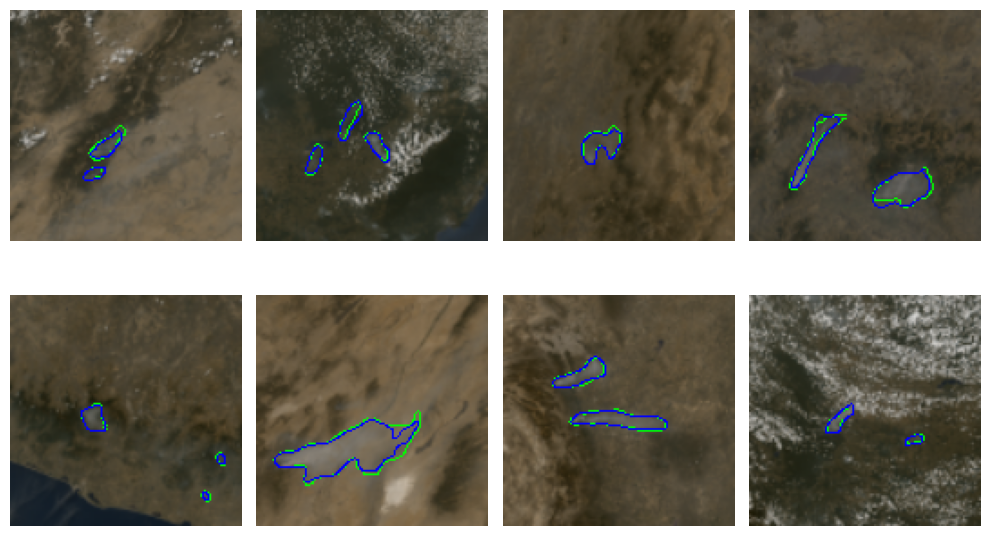

In [47]:

#print(preds.shape)
plot_mini_batch_two(imgs_test,preds.unsqueeze(1), masks_test, [0, 1, 0], [0, 0, 1])  #[0, 0, 1]=verde=true,  [0, 1, 0]=blue=pred